# SABR and the volatility smile calibration
#### Roland Grinis - MIPT & GrinisRIT

This is a stochastic volatility model that describes the dynamics of the forward directly in the risk neutral measure:

$$
\begin{split}
\text{d}f_t & =  \sigma_t f_t^\beta \text{d}W_t^1   \\
\text{d}\sigma_t & =  \upsilon \sigma_t \left( \rho \text{d}W_t^1 + \sqrt{1-\rho^2} \text{d}W_t^2 \right) 
\end{split}
$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ is the CIR exponent and the Wiener processes are independent.

In [1]:
import torch
from torch.utils.cpp_extension import load
import numpy as np
import numba as nb
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
torch.manual_seed(987654);

In [3]:
!mkdir -p build

In [8]:
sabr = load(name='sabr',
             build_directory='./build',
             sources=['sabr.cc'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

ImportError: DLL load failed while importing sabr: The specified module could not be found.

In [5]:
a = torch.randn(5, dtype=torch.float64)

In [6]:
sabr.test(a)

NameError: name 'sabr' is not defined

## 1. Implied Volatility

##### CDF Approximation
Zelen & Severo approximation for the standard normal CDF $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is given by: 
$$
\text{N}(x) = 1 - \text{N}'(x) \sum_{i=1}^{5} b_i t^i + \epsilon (x)
$$
where $t = (1 + b_0 x)^{-1}$, the error is bounded by $|\epsilon (x)| < 7.5 \cdot 10^{-8}$ and the coefficients $b_i$ are fixed (see implementation).

```cpp
inline const double b0 = 0.2316419;
inline const double b1 = 0.319381530;
inline const double b2 = -0.356563782;
inline const double b3 = 1.781477937;
inline const double b4 = -1.821255978;
inline const double b5 = 1.330274429;
```


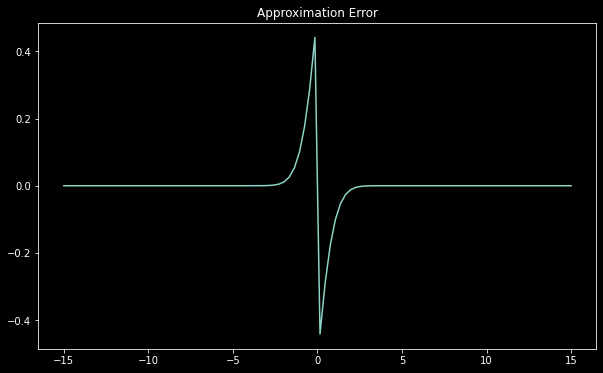

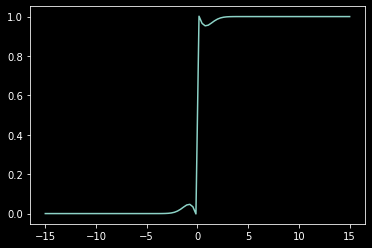

In [4]:
@nb.njit()
def cdf(x):
    t = 1 / (1 + 0.2316419*abs(x))
    summ = 0.319381530*t - 0.356563782*t**2 + 1.781477937*t**3 - 1.821255978*t**4 + 1.330274429*t**5
    if x >= 0:
        return 1 - summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)
    else:
        return summ * np.exp(-abs(x)**2 / 2) / np.sqrt(2*np.pi)

x = np.linspace(-15, 15, 100)
N0 = norm.cdf(x)
N1 = tuple(map(cdf, x))

plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.plot(x, N0 - np.array(N1))
plt.title('Approximation Error')
plt.show()

plt.plot(x, N1)

##### Newton-Raphson

$$
g\left(\sigma_{\text {imp }}\right)=V^{m k t}(K, T)-V\left(t_0=0, S_0 ; K, T, \sigma_{\text {imp }}, r\right)=0 .
$$

Given an initial guess for the implied volatility, i.e. $\sigma_{\text {imp }}^{(0)}$, we can find the next approximations, $\sigma_{\text {imp }}^{(k)}, k=1,2, \ldots$, by means of the Newton-Raphson iterative algorythm, as follows

$$
\sigma_{\text {imp }}^{(k+1)}=\sigma_{\text {imp }}^{(k)}-\frac{g\left(\sigma_{\text {imp }}^{(k)}\right)}{g^{\prime}\left(\sigma_{\text {imp }}^{(k)}\right)}, \text { for } k \geq 0 .
$$


##### Combined Algorithm (Newton-Raphson + Bisection):

Determine initial interval $\left[\sigma_{\text {imp }}^l, \sigma_{\text {imp }}^r\right]$
If $g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^r\right)>0$ stop (there is no zero in the interval)

Else: $\delta=-\frac{g\left(\sigma_{imp}^{(k)}\right)} {g^{\prime}\left(\sigma_{imp}^{(k)}\right)}$;
      $ \sigma_{imp}^{(0)} = \frac{1}{2} (\sigma_{imp}^l + \sigma_{imp}^r)$

While $\delta / \sigma_{imp}^{(k)}>$ tolerance:

$$
\sigma_{imp}^{(k+1)}=\sigma_{imp}^{(k)}+\delta \\
\text { if } \sigma_{imp}^{(k+1)} \notin\left[\sigma_{imp}^l, \sigma_{imp}^r\right]: \\

\quad \text { if } g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^{(k+1)}\right)>0 \text {, then } \sigma_{imp}^l=\sigma_{imp}^{(k)} \\
\quad \text { if } g\left(\sigma_{imp}^l\right) \cdot g\left(\sigma_{imp}^{(k+1)}\right)<0 \text {, then } \sigma_{imp}^r=\sigma_{imp}^{(k)} \\
\quad \sigma_{imp}^{(k+1)}=\left(\sigma_{imp}^l+\sigma_{imp}^r\right) / 2 \\
\delta=-g\left(\sigma_{imp}^{(k+1)}\right) / g^{\prime}\left(\sigma_{imp}^{(k+1)}\right) \\
$$

In [13]:
@nb.njit()
def g(sigma, V_mkt, dt, s0, K, r, call=True):
    d1 = (np.log(s0/K) + (r + sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d2 = d1 - sigma * np.sqrt(dt)
    p = 1 if call else -1
    # V = p*s0*norm.cdf(p*d1, 0,1) - p*K*np.exp(-r*dt)*norm.cdf(p*d2, 0,1)
    V = p*s0*cdf(p*d1) - p*K*np.exp(-r*dt)*cdf(p*d2)
    return V_mkt - V


@nb.njit()
def g_prime(sigma, dt, s0, K, r):
    dist = (np.log(s0/K) + (r - sigma**2/2)*dt) / (sigma*dt)
    return -K*np.exp(-r*dt) * np.sqrt(dt) * np.exp(-dist**2 / 2) / np.sqrt(2*np.pi)

@nb.njit()
def root_finder(V_mkt, dt, s0, K, r, call=True, tol=10**-8, sigma_l=10**-8, sigma_r=1):
    if g(sigma_l, V_mkt, dt, s0, K, r, call)*g(sigma_r, V_mkt, dt, s0, K, r, call) > 0:
        print('no zero at the initial interval')
    else:
        sigma = (sigma_l + sigma_r) / 2
        shift = - g(sigma, V_mkt, dt, s0, K, r, call) / g_prime(sigma, dt, s0, K, r)

        while shift / sigma > tol:
            sigma = sigma + shift
            if sigma > sigma_r or sigma < sigma_l:
                if g(sigma_l, V_mkt, dt, s0, K, r, call)*g(sigma, V_mkt, dt, s0, K, r, call) > 0:
                    sigma_l = sigma
                else:
                    sigma_r = sigma

                sigma = (sigma_l + sigma_r) / 2

            shift = - g(sigma, V_mkt, dt, s0, K, r, call) / g_prime(sigma, dt, s0, K, r)
        return sigma

In [14]:
root_finder(10, 1, 100, 150, 0.1)

0.5136388807425428

### References
* Hagan, P. S. et al. *Implied volatility formulas for Heston models.* Wilmott 2018.98 (2018)
* Bartlett, B. *Hedging Under SABR Model.* Wilmott Magazine, (2006)
* Oblój, J. *Fine-Tune Your Smile: Correction to Hagan et al*. preprint arXiv:0708.0998 (2007)
* Paulot, L. *Asymptotic implied volatility at the second order with application to the SABR model.* In Large Deviations and Asymptotic Methods in Finance (pp. 37-69). Springer, Cham. (2015)
* Henry-Labordère, P. *A general asymptotic implied volatility for stochastic volatility
models.* http://arxiv.org/abs/cond-mat/0504317 (2005)